In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
#local_dir = r"C:\Users\nicol\OneDrive\Desktop\scuola\NETWORK SCIENCE\progetto\data\\"
local_dir = "data/"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [3]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Country Code', 'Sending Organization','Receiving Country Code', 'Receiving Organization',
                    'Participants', 'Sending City', 'Receiving City']]
    return df

mobility_df = filter_data(mobility_df)

mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

In [4]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] == 'IT')&(mobility_df['Receiving Country Code'] == 'IT')].index)
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] != 'IT')&(mobility_df['Receiving Country Code'] != 'IT')].index)

from_italy = mobility_df[mobility_df['Sending Country Code'] == 'IT']
to_italy = mobility_df[mobility_df['Receiving Country Code'] == 'IT']

mobility_df = pd.concat((from_italy, to_italy))

print('Number of Italian Receiving Universities: ',(to_italy['Receiving Organization'].nunique()))
print('Number of Italian Sending Universities: ',(from_italy['Sending Organization'].nunique()))

Number of Italian Receiving Universities:  241
Number of Italian Sending Universities:  220


In [5]:
italian_nodes = np.array(list(set.union(set(from_italy.loc[:, 'Sending Organization']), set(to_italy.loc[:, 'Receiving Organization']))))
number_of_italian_node = len(italian_nodes)
print('Number of italian universities', number_of_italian_node)
not_italian_nodes = np.array(list(set.union(set(to_italy.loc[:, 'Sending Organization']), set(from_italy.loc[:, 'Receiving Organization']))))
nodes = np.concatenate((italian_nodes, not_italian_nodes))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))

Number of italian universities 275


In [6]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['SendId']>number_of_italian_node) & (mobility_df['RecId']>number_of_italian_node)].index)

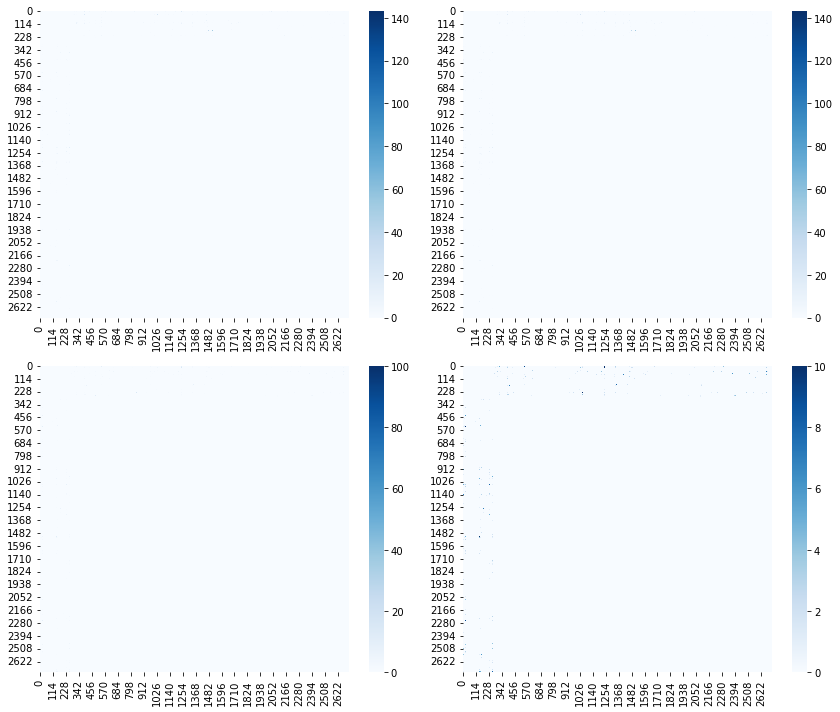

In [7]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
ns.visualize_adj(adj_matrix_crs)

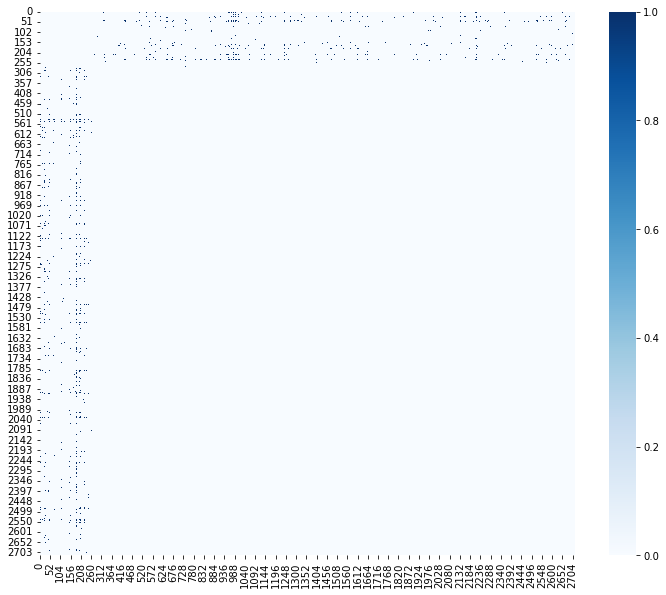

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

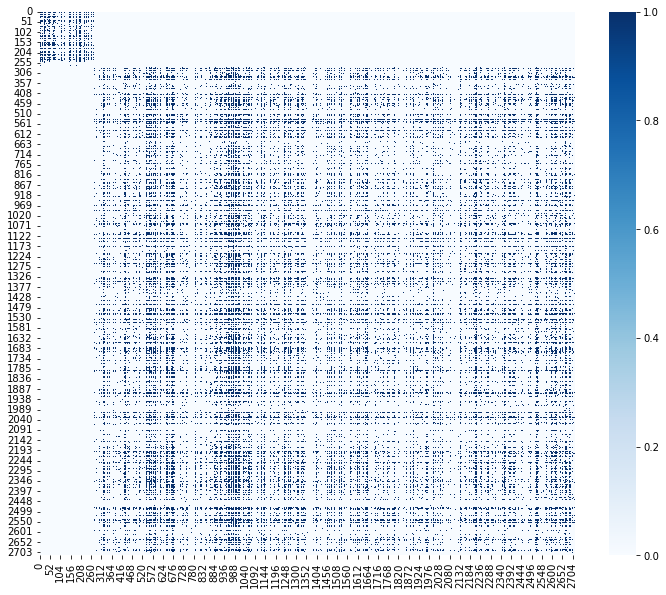

In [9]:
projection = adj_matrix_crs**2
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = projection.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

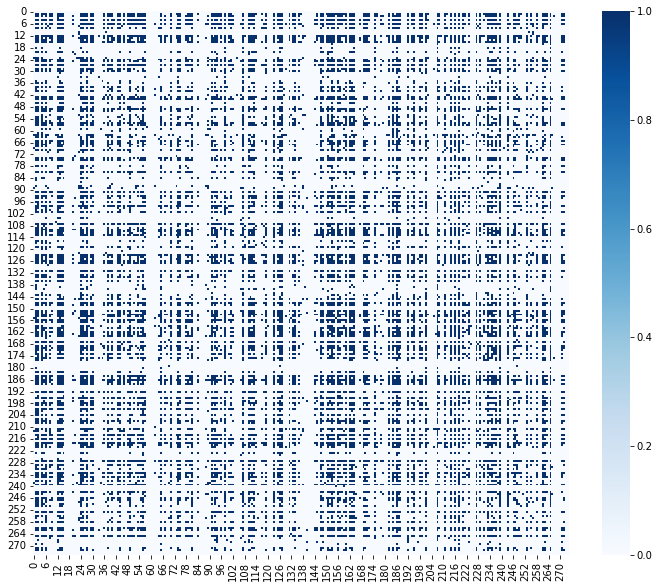

In [10]:
italian_matrix = projection[0:number_of_italian_node, 0:number_of_italian_node]
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = italian_matrix.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [11]:
italian_df = pd.DataFrame(italian_nodes, columns=['Sending Organization'])
italian_df['SendId'] = (np.array(list(map(lambda x: node_position[x], italian_df['Sending Organization']))))
italian_df2 = pd.DataFrame(italian_nodes, columns=['Receiving Organization'])
italian_df2['RecId'] = (np.array(list(map(lambda x: node_position[x], italian_df2['Receiving Organization']))))
italian_df = italian_df.merge(italian_df2, how='cross')
italian_df['Participants'] = np.nan

rows, columns = italian_matrix.nonzero()
for r,c in zip(rows, columns):
    italian_df.at[(italian_df['SendId'] == c) &(italian_df['RecId'] == r), 'Participants']= italian_matrix[r,c]

italian_df = italian_df.dropna()
italian_df

,Sending Organization,SendId,Receiving Organization,RecId,Participants
23,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,0,CONSERVATORIO DI MUSICA G.B.MARTINI,23,1.0
62,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,0,"CONSERVATORIO DI MUSICA ""SANTA CECILIA""",62,3.0
69,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,0,CONSERVATORIO DI MUSICA DI PERUGIA,69,1.0
89,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,0,"CONSERVATORIO DI MUSICA ""G.VERDI"" DI MILANO",89,1.0
155,CONSERVATORIO DI MUSICA DI LECCE - TITO SCHIPA,0,"CONSERVATORIO DI MUSICA ""CLAUDIO MONTEVERDI"" M...",155,1.0
...,...,...,...,...,...
75058,ACCADEMIA DI BELLE ARTI DI URBINO,272,UNIVERSITA DEGLI STUDI MEDITERRANEA DI REGGIO ...,258,2.0
75061,ACCADEMIA DI BELLE ARTI DI URBINO,272,UNIVERSITA DEGLI STUDI DI PAVIA,261,25.0
75062,ACCADEMIA DI BELLE ARTI DI URBINO,272,ACCADEMIA DI BELLE ARTI DI BOLOGNA,262,7.0
75065,ACCADEMIA DI BELLE ARTI DI URBINO,272,UNIVERSITA DEGLI STUDI DI CAGLIARI,265,13.0


In [12]:
uni_cities = mobility_df.copy()
mobility_df = italian_df
adj_matrix_crs = italian_matrix
nodes_df = pd.DataFrame({'Nodes': italian_nodes})

mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)

nodes_component = ns.find_components(adj_matrix_crs, nodes_df)
components_n = nodes_component.groupby(by=["component"]).count()
display(components_n)
for i in range(1, 12):
    print("component ", i )
    nodes_component_i = nodes_component[nodes_component['component'] == i]
    display(nodes_component_i)

,Nodes
component,
0,253
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1


component  1


,Nodes,component
17,UNIVERSITY OF THE WEST OF SCOTLAND,1


component  2


,Nodes,component
19,UNIVERSITE CATHOLIQUE DE LOUVAIN,2


component  3


,Nodes,component
32,UNIVERSIDADE DE LISBOA,3


component  4


,Nodes,component
47,UNIVERSITE LYON 1 CLAUDE BERNARD,4


component  5


,Nodes,component
58,FONDAZIONE ISTITUTO TECNICO SUPERIORE PER LE N...,5


component  6


,Nodes,component
72,INSTITUTO POLITÉCNICO DE CASTELO BRANCO,6


component  7


,Nodes,component
76,ACCADEMIA DI BELLE ARTI ALDO GALLI - I.L.E.M. SRL,7


component  8


,Nodes,component
77,CONSERVATORIO DI MUSICA ALFREDO CASELLA,8


component  9


,Nodes,component
83,UNIVERSITE FRANCOIS RABELAIS DE TOURS,9


component  10


,Nodes,component
103,ISTITUTO SUPERIORE PER LE INDUSTRIE ARTISTICHE...,10


component  11


,Nodes,component
130,CONSERVATORIO SAN PIETRO A MAJELLA,11


In [13]:
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

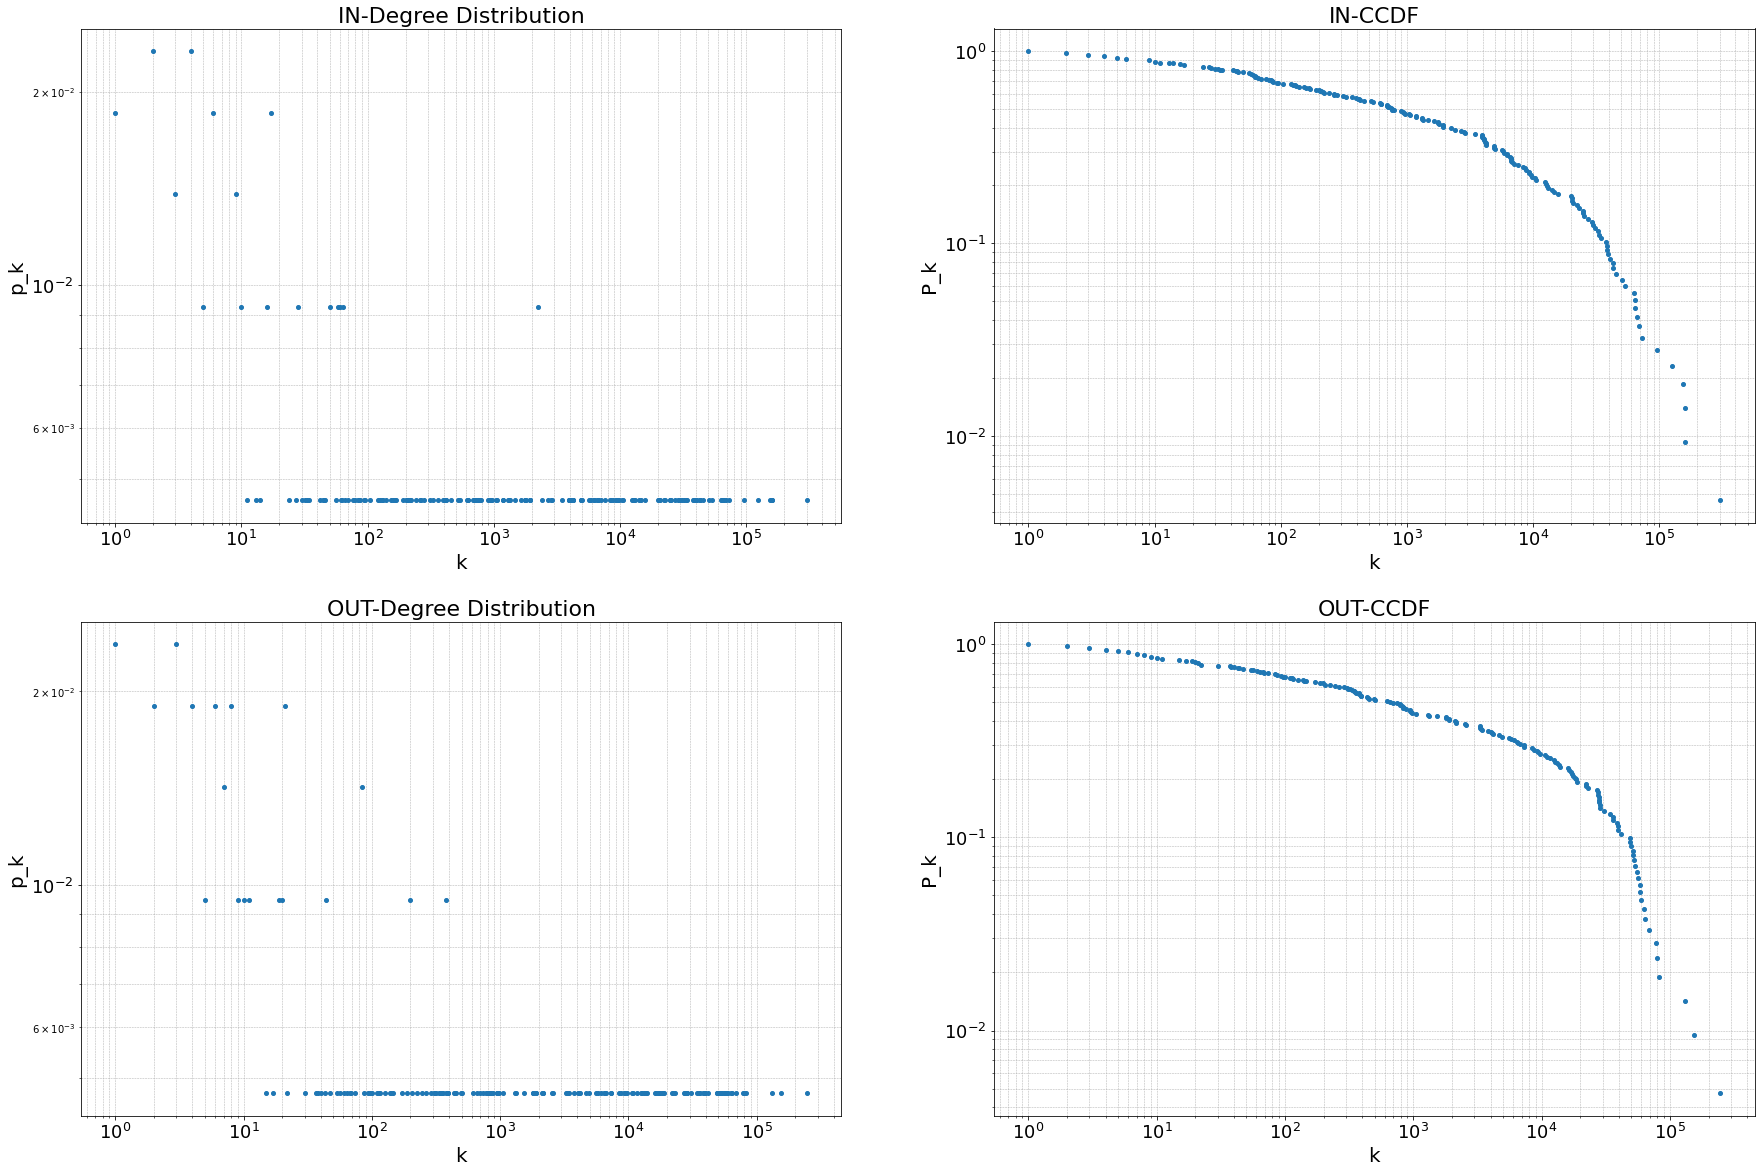

Top 10 for in degree


,Nodes,in degree
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,301706
12,POLITECNICO DI MILANO,160089
141,UNIVERSITA DEGLI STUDI DI PADOVA,159396
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,153476
210,UNIVERSITA DEGLI STUDI DI FIRENZE,124632
222,UNIVERSITA DEGLI STUDI DI TORINO,95062
8,UNIVERSITA COMMERCIALE LUIGI BOCCONI,73057
1,UNIVERSITA DEGLI STUDI DI MILANO,69468
23,POLITECNICO DI TORINO,66288
89,UNIVERSITA DEGLI STUDI ROMA TRE,64534


Top 10 for out degree


,Nodes,out degree
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,245660
222,UNIVERSITA DEGLI STUDI DI TORINO,153099
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,131231
141,UNIVERSITA DEGLI STUDI DI PADOVA,82361
1,UNIVERSITA DEGLI STUDI DI MILANO,79256
184,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,78029
12,POLITECNICO DI MILANO,68569
116,UNIVERSITA DEGLI STUDI DI SASSARI,64256
190,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,63093
4,UNIVERSITA DEGLI STUDI DI TRIESTE,59143


In [14]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [15]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 1500
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [16]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

1.4701897037112337 1.429720479862956


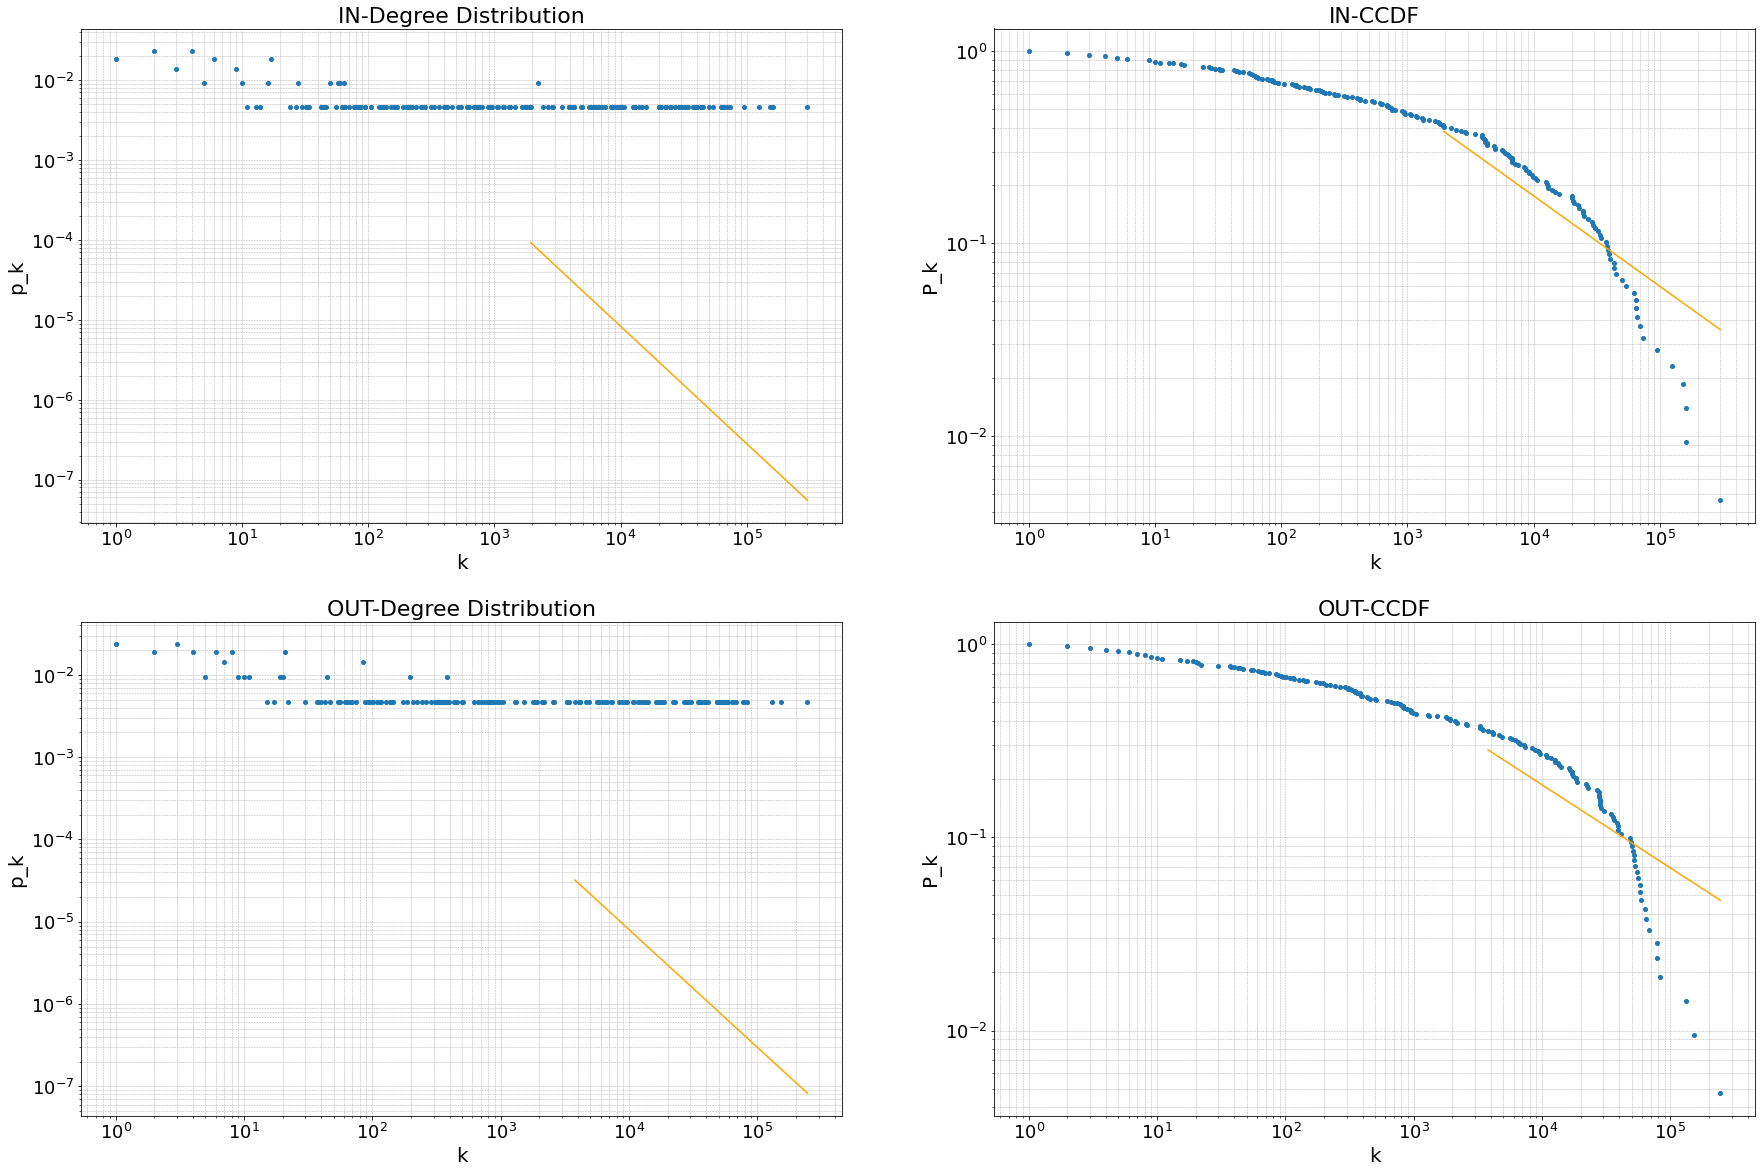

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    idx = 100 
    ax.loglog(x[100:], p[100:], color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
print(ga_in, ga_out)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [18]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )
kmin = 100
mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

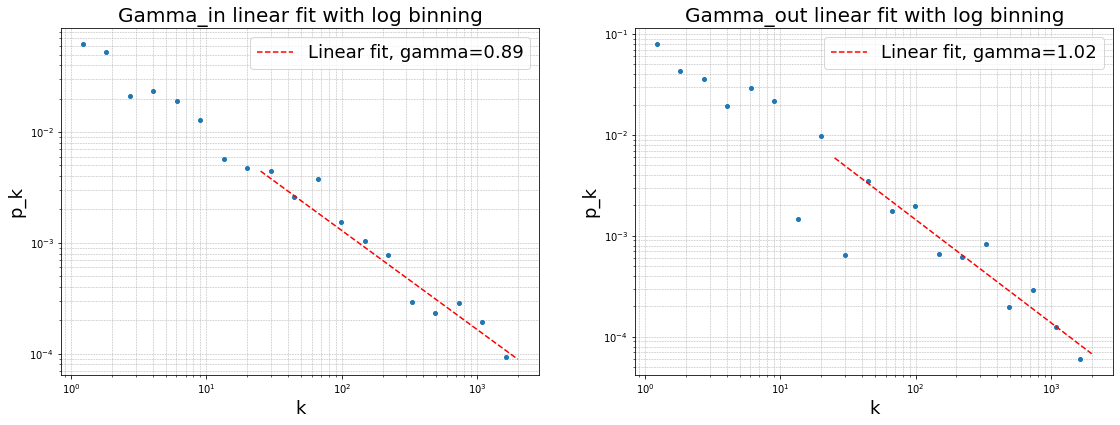

In [19]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

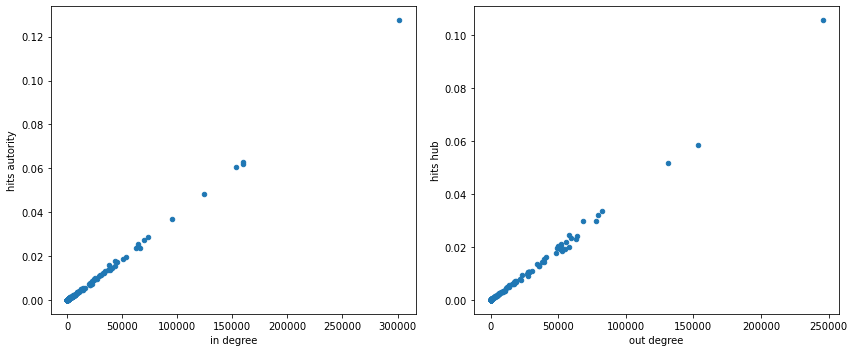

Top 10 for hits hub


,Nodes,hits hub
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.105405
222,UNIVERSITA DEGLI STUDI DI TORINO,0.058449
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.051489
141,UNIVERSITA DEGLI STUDI DI PADOVA,0.033370
1,UNIVERSITA DEGLI STUDI DI MILANO,0.031825
184,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.029831
12,POLITECNICO DI MILANO,0.029679
23,POLITECNICO DI TORINO,0.024470
116,UNIVERSITA DEGLI STUDI DI SASSARI,0.024036
4,UNIVERSITA DEGLI STUDI DI TRIESTE,0.023270


Top 10 for hits autority


,Nodes,hits autority
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.127436
141,UNIVERSITA DEGLI STUDI DI PADOVA,0.062870
12,POLITECNICO DI MILANO,0.062068
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.060527
210,UNIVERSITA DEGLI STUDI DI FIRENZE,0.048215
222,UNIVERSITA DEGLI STUDI DI TORINO,0.036840
8,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.028748
1,UNIVERSITA DEGLI STUDI DI MILANO,0.027372
89,UNIVERSITA DEGLI STUDI ROMA TRE,0.025541
6,UNIVERSITA DI PISA,0.024542


In [20]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

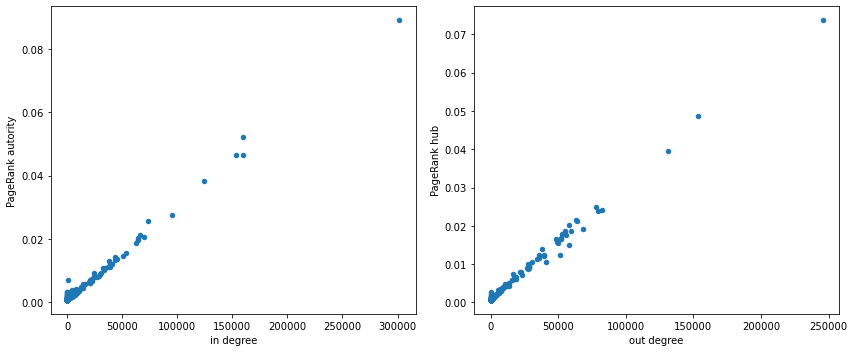

Top 10 for PageRank hub


,Nodes,PageRank hub
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.073620
222,UNIVERSITA DEGLI STUDI DI TORINO,0.048671
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.039597
184,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.024867
141,UNIVERSITA DEGLI STUDI DI PADOVA,0.024257
1,UNIVERSITA DEGLI STUDI DI MILANO,0.023997
190,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,0.021579
116,UNIVERSITA DEGLI STUDI DI SASSARI,0.021314
2,UNIVERSITA DEGLI STUDI DI PALERMO,0.020312
12,POLITECNICO DI MILANO,0.019061


Top 10 for PageRank autority


,Nodes,PageRank autority
173,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.089071
12,POLITECNICO DI MILANO,0.052143
201,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.046395
141,UNIVERSITA DEGLI STUDI DI PADOVA,0.046374
210,UNIVERSITA DEGLI STUDI DI FIRENZE,0.038281
222,UNIVERSITA DEGLI STUDI DI TORINO,0.027461
8,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.025661
23,POLITECNICO DI TORINO,0.021383
1,UNIVERSITA DEGLI STUDI DI MILANO,0.020497
6,UNIVERSITA DI PISA,0.020148


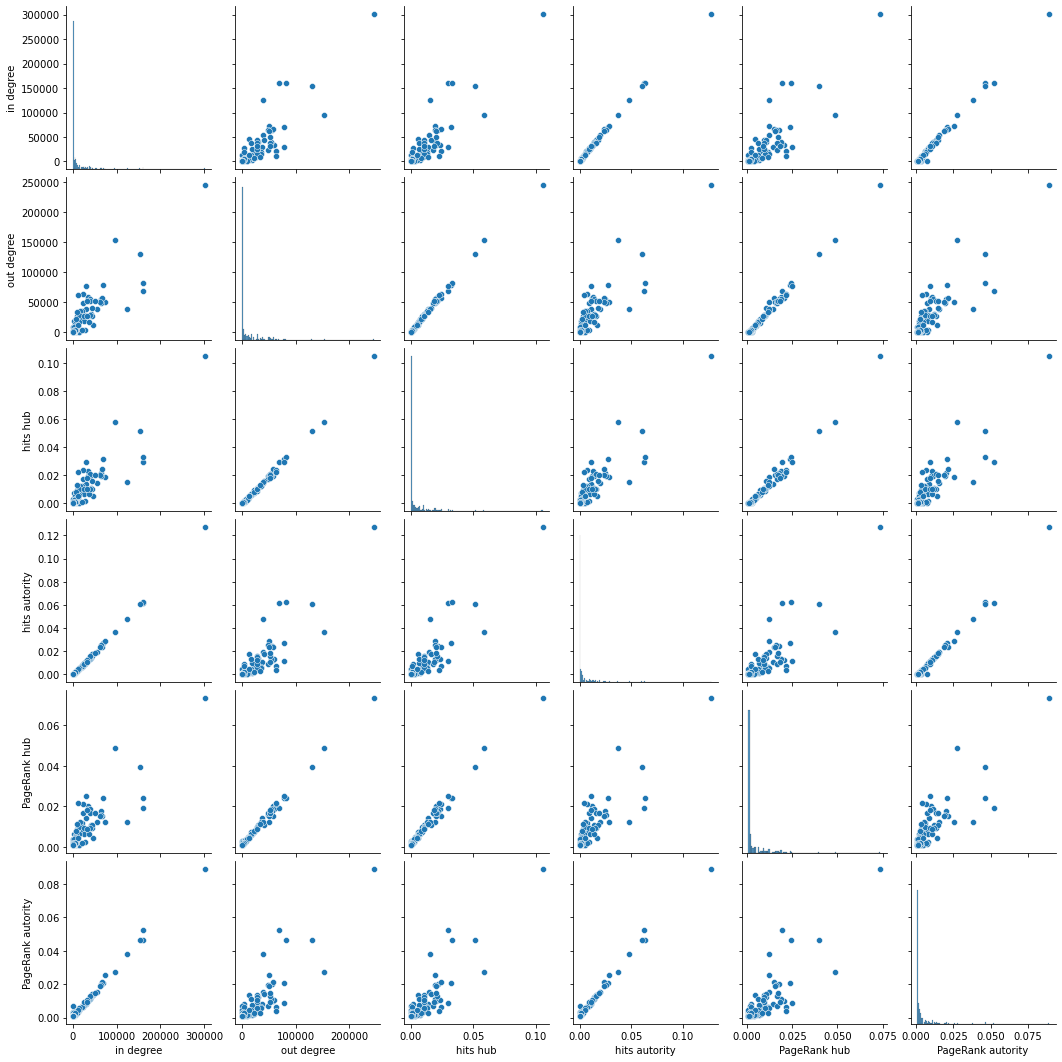

In [21]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

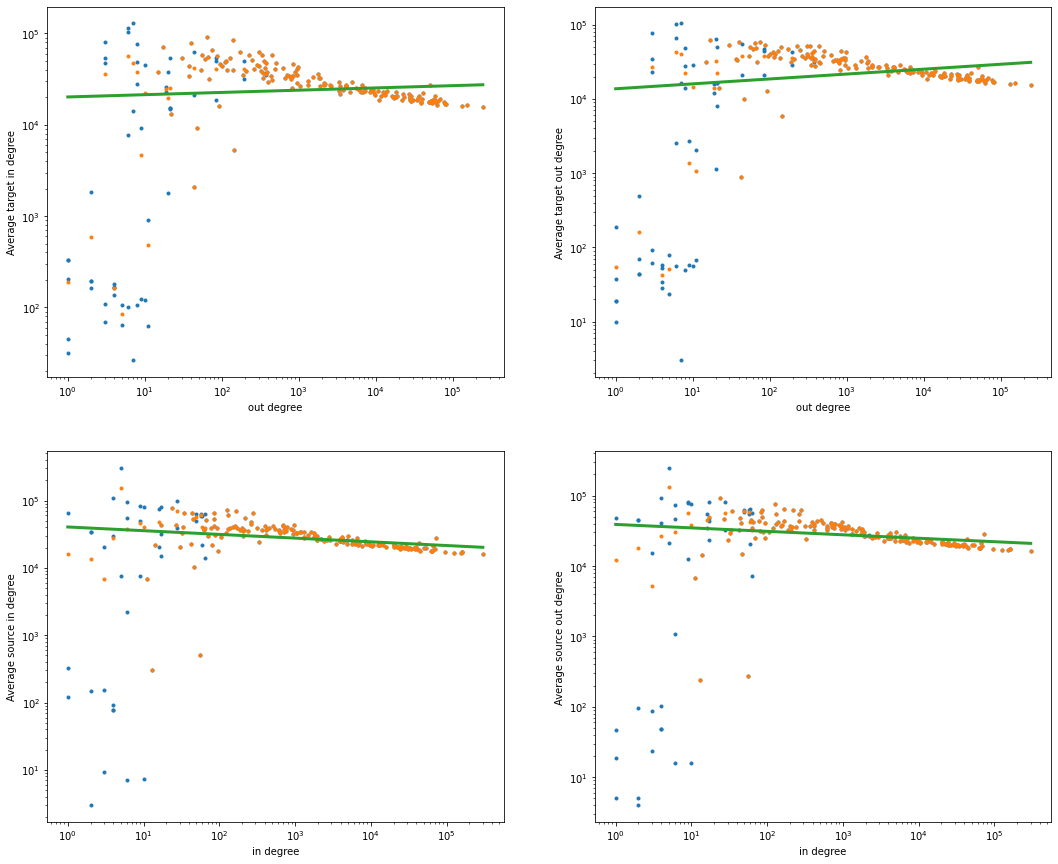

(0.024754664537987595,
 0.06605393866346729,
 -0.0550812750752602,
 -0.04910790590356632)

In [22]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [23]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [24]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

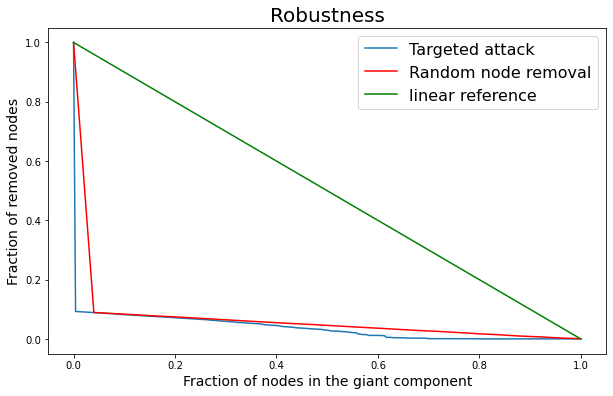

In [25]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()

## Geographic plots

In [26]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']
geo_df = geo_df.loc[geo_df['country'] == 'Italy']

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City,city,city_ascii,lat,lng,iso2,admin_name
0,UNIVERSITA DEGLI STUDI DI PALERMO,2,33238,58022,2,1.994971e-02,0.012102,2,0.020312,0.010059,PALERMO,PALERMO,Palermo,38.1157,13.3613,IT,Sicilia
1,UNIVERSITA DEGLI STUDI DI TRIESTE,4,34161,59143,4,2.326966e-02,0.012920,4,0.018567,0.010656,TRIESTE,TRIESTE,Trieste,45.6503,13.7703,IT,Friuli-Venezia Giulia
2,UNIVERSITA DI PISA,6,64153,56015,6,2.185072e-02,0.024542,6,0.017608,0.020148,PISA,PISA,Pisa,43.7167,10.4000,IT,Tuscany
3,UNIVERSITA COMMERCIALE LUIGI BOCCONI,8,73057,51181,8,1.908915e-02,0.028748,8,0.012352,0.025661,MILAN,MILAN,Milan,45.4669,9.1900,IT,Lombardy
4,UNIVERSITA DEGLI STUDI DELLA CAMPANIA LUIGI VA...,14,9212,26871,14,9.572619e-03,0.003407,14,0.009008,0.003330,CASERTA,CASERTA,Caserta,41.0667,14.3333,IT,Campania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,"ISTITUTO SUPERIORE DI STUDI MUSICALI ""FRANCO V...",241,0,3,241,7.392961e-07,0.000000,241,0.000721,0.000746,PAVIA,PAVIA,Pavia,45.1853,9.1550,IT,Lombardy
73,UNIVERSITA DEGLI STUDI DI PAVIA,242,50380,51793,242,2.032372e-02,0.018805,242,0.016908,0.014609,PAVIA,PAVIA,Pavia,45.1853,9.1550,IT,Lombardy
74,"CONSERVATORIO DI MUSICA ""GIUSEPPE NICOLINI""",247,17,9,247,1.756830e-07,0.000002,247,0.000785,0.000990,PIACENZA,PIACENZA,Piacenza,45.0500,9.7000,IT,Emilia-Romagna
75,ACCADEMIA ABADIR (ENTE GESTORE R.AR.A. SRL),248,63,6,248,2.739998e-06,0.000009,248,0.000700,0.000871,CATANIA,CATANIA,Catania,37.5027,15.0873,IT,Sicilia


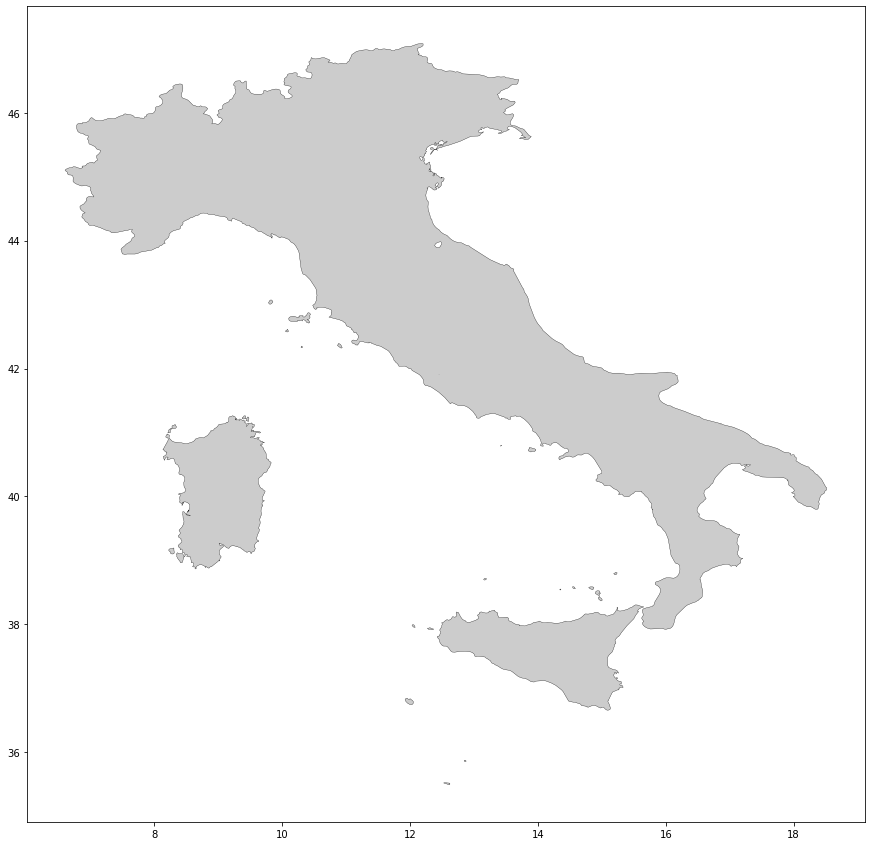

In [46]:
temp_df = uni_cities[['Receiving Organization', 'Receiving City']].copy()
temp_df.rename({'Receiving Organization':'Sending Organization', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['Sending Organization', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)
cities_uni.dropna(subset=['Sending City'], inplace=True)

# for index in range(cities_uni.shape[0]):
#     city = cities_uni.iat[index,1]
#     if city != city.upper():
#         cities_uni.iat[index,1] = city.upper()
cities_uni['Sending Organization'] = cities_uni['Sending Organization'].str.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
# cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['Sending Organization'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
city_coord = city_coord.loc[city_coord['iso2'] == 'IT']
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino (these are also pretty much important)

In [47]:
scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City,city,city_ascii,lat,lng,iso2,admin_name
0,UNIVERSITA DEGLI STUDI DI PALERMO,2,33238,58022,2,1.994971e-02,0.012102,2,0.020312,0.010059,PALERMO,PALERMO,Palermo,38.1157,13.3613,IT,Sicilia
1,UNIVERSITA DEGLI STUDI DI TRIESTE,4,34161,59143,4,2.326966e-02,0.012920,4,0.018567,0.010656,TRIESTE,TRIESTE,Trieste,45.6503,13.7703,IT,Friuli-Venezia Giulia
2,UNIVERSITA DI PISA,6,64153,56015,6,2.185072e-02,0.024542,6,0.017608,0.020148,PISA,PISA,Pisa,43.7167,10.4000,IT,Tuscany
3,UNIVERSITA COMMERCIALE LUIGI BOCCONI,8,73057,51181,8,1.908915e-02,0.028748,8,0.012352,0.025661,MILAN,MILAN,Milan,45.4669,9.1900,IT,Lombardy
4,UNIVERSITA DEGLI STUDI DELLA CAMPANIA LUIGI VA...,14,9212,26871,14,9.572619e-03,0.003407,14,0.009008,0.003330,CASERTA,CASERTA,Caserta,41.0667,14.3333,IT,Campania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,"ISTITUTO SUPERIORE DI STUDI MUSICALI ""FRANCO V...",241,0,3,241,7.392961e-07,0.000000,241,0.000721,0.000746,PAVIA,PAVIA,Pavia,45.1853,9.1550,IT,Lombardy
73,UNIVERSITA DEGLI STUDI DI PAVIA,242,50380,51793,242,2.032372e-02,0.018805,242,0.016908,0.014609,PAVIA,PAVIA,Pavia,45.1853,9.1550,IT,Lombardy
74,"CONSERVATORIO DI MUSICA ""GIUSEPPE NICOLINI""",247,17,9,247,1.756830e-07,0.000002,247,0.000785,0.000990,PIACENZA,PIACENZA,Piacenza,45.0500,9.7000,IT,Emilia-Romagna
75,ACCADEMIA ABADIR (ENTE GESTORE R.AR.A. SRL),248,63,6,248,2.739998e-06,0.000009,248,0.000700,0.000871,CATANIA,CATANIA,Catania,37.5027,15.0873,IT,Sicilia


(6.006993428750065, 19.113160860250133, 34.90944532885, 47.66501349815003)

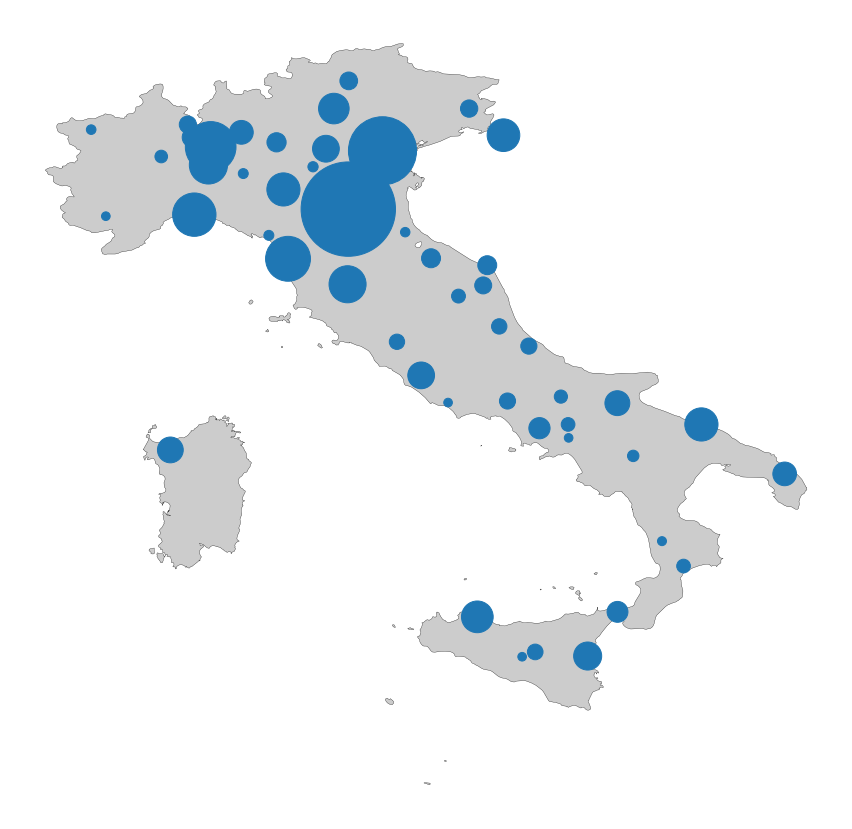

In [49]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey', 'gold', 'aqua', 'fuchsia', 'pink', 'yellow', 'salmon', 
          'khaki', 'brown', 'lime', 'skyblue', 'peachpuff', 'ivory', 'powderblue', 'rosybrown', 'royalblue', 
          'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue',
          'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet',
          'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen', 'lightgreen', 'lightgray', 'lightpink', 'lightsalmon', 
          'lightseagreen', 'lightskyblue', 'lightslategray']

fig, ax = plt.subplots(figsize=(20,15))

geo_df.plot(ax=ax, edgecolor='0', linewidth=0.3, color='0.8')
ax.scatter(x=scores_cities['lng'], y=scores_cities['lat'], s=scores_cities['PageRank autority']*10**5)
ax.axis('off')